In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import xarray as xr
import pandas as pd
from glob import glob
from keras.models import load_model
from deepsky.gan import stack_gen_encoder
import keras.backend as K

Using TensorFlow backend.


In [2]:
patch_files = sorted(glob("/scratch/dgagne/storm_gan/gan_gen_patches*.nc"))

In [70]:
out_path = "/scratch/dgagne/storm_gan_images/"
for patch_file in patch_files:
    print(patch_file)
    patches = xr.open_dataset(patch_file)
    patch_file_comps = patch_file.split("/")[-1][:-3].split("_")
    config = int(patch_file_comps[3])
    epoch = int(patch_file_comps[5])
    fig, axes = plt.subplots(4, 4, figsize=(20, 20))
    plt.subplots_adjust(0.01, 0.01, 0.95, 0.95, hspace=0, wspace=0)
    cax = fig.add_axes([0.96, 0.02, 0.03, 0.9])
    axef = axes.ravel()
    for a, ax in enumerate(axef):
        cont = ax.contourf(patches["gen_patch"][a, :, :, 0], np.arange(0, 80, 5), cmap="gist_ncar")
        ax.barbs(np.arange(0, 64, 8), np.arange(0, 64, 8), 
                 patches["gen_patch"][a, ::8, ::8, 3], patches["gen_patch"][a, ::8, ::8, 4], length=4)
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        ax.set_xlim(0, 64)
        ax.set_ylim(0, 64)
    cbar = fig.colorbar(cont, cax=cax)
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_ylabel("Radar Reflectivity (dBZ)", fontsize=18)
    fig.suptitle("GAN Generated Radar Images Config {0:d} Epoch {1:d}".format(config, epoch), 
                 fontsize=20, fontweight="bold", y=0.97)
    plt.savefig(out_path + "storm_gan_radar_config_{0:03d}_epoch_{1:02d}_images_{2:03d}.png".format(config,
                                                                                              epoch,
                                                                                              axef.size),
               dpi=300, bbox_inches="tight")
    plt.close()
    patches.close()

/scratch/dgagne/storm_gan/gan_gen_patches_000000_epoch_0001.nc
/scratch/dgagne/storm_gan/gan_gen_patches_000000_epoch_0005.nc
/scratch/dgagne/storm_gan/gan_gen_patches_000000_epoch_0010.nc
/scratch/dgagne/storm_gan/gan_gen_patches_000001_epoch_0001.nc
/scratch/dgagne/storm_gan/gan_gen_patches_000001_epoch_0005.nc
/scratch/dgagne/storm_gan/gan_gen_patches_000001_epoch_0010.nc
/scratch/dgagne/storm_gan/gan_gen_patches_000002_epoch_0001.nc
/scratch/dgagne/storm_gan/gan_gen_patches_000002_epoch_0005.nc
/scratch/dgagne/storm_gan/gan_gen_patches_000002_epoch_0010.nc
/scratch/dgagne/storm_gan/gan_gen_patches_000003_epoch_0001.nc
/scratch/dgagne/storm_gan/gan_gen_patches_000003_epoch_0005.nc
/scratch/dgagne/storm_gan/gan_gen_patches_000003_epoch_0010.nc
/scratch/dgagne/storm_gan/gan_gen_patches_000004_epoch_0001.nc
/scratch/dgagne/storm_gan/gan_gen_patches_000004_epoch_0005.nc
/scratch/dgagne/storm_gan/gan_gen_patches_000004_epoch_0010.nc
/scratch/dgagne/storm_gan/gan_gen_patches_000005_epoch_

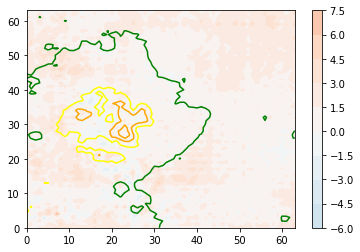

In [94]:
patches = xr.open_dataset(patch_files[-1])
dewp_dep = plt.contourf(patches["gen_patch"][8, :, :, 1] - patches["gen_patch"][8, :, :, 2], cmap="RdBu_r", vmin=-25, vmax=25)
plt.contour(patches["gen_patch"][2, :, :, 0], [20, 40, 50, 60], cmap=ListedColormap(["green", "yellow", "orange"]))
plt.colorbar(dewp_dep)

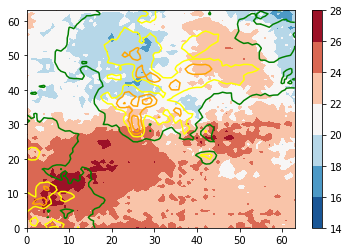

In [122]:
patches = xr.open_dataset(patch_files[-4])
p_num = 32
temp = plt.contourf(patches["gen_patch"][p_num, :, :, 2] - 273, cmap="RdBu_r")
plt.contour(patches["gen_patch"][p_num, :, :, 0], [20, 40, 50, 60], cmap=ListedColormap(["green", "yellow", "orange"]))
plt.colorbar(temp)
patches.close()

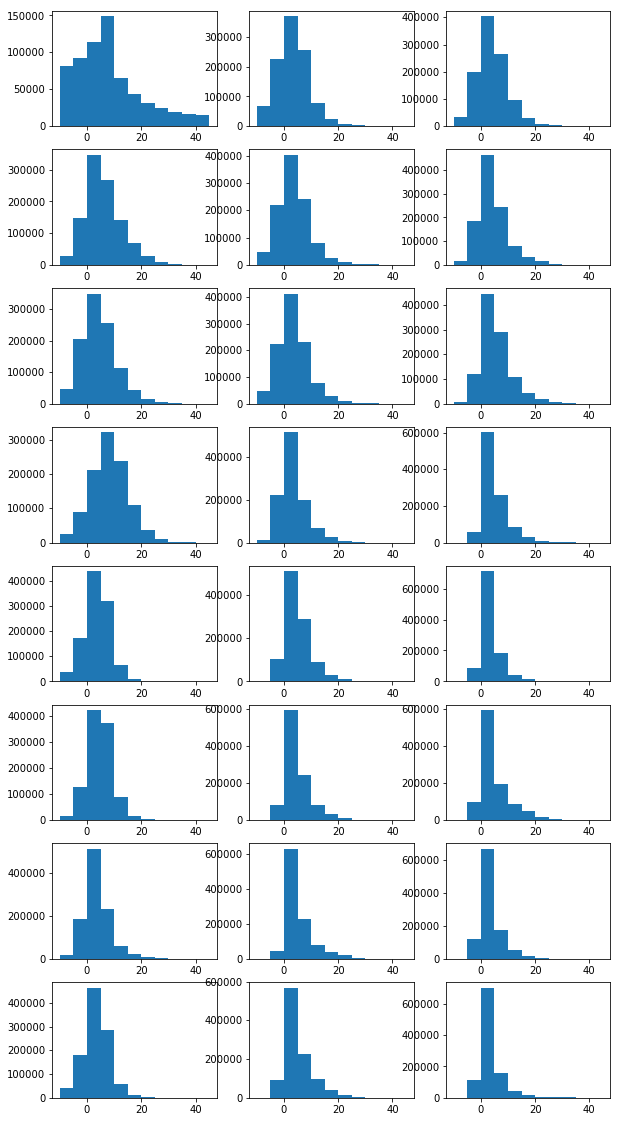

In [103]:
fig, axes = plt.subplots(len(patch_files) // 3, 3, figsize=(10, 20))
axef = axes.ravel()
for p, patch_file in enumerate(patch_files):
    patches = xr.open_dataset(patch_file)
    patch_file_comps = patch_file.split("/")[-1][:-3].split("_")
    config = int(patch_file_comps[3])
    epoch = int(patch_file_comps[5])
    dewp_dep = (patches["gen_patch"][:, :, :, 1] - patches["gen_patch"][:, :, :, 2]).values.ravel()
    axef[p].hist(dewp_dep, np.arange(-10, 50, 5))
    patches.close()

In [5]:
configs = []
epochs = []
for p, patch_file in enumerate(patch_files):
    patch_file_comps = patch_file.split("/")[-1][:-3].split("_")
    config = int(patch_file_comps[3])
    epoch = int(patch_file_comps[5])
    configs.append(config)
    epochs.append(epoch)
configs = np.unique(configs)
epochs = np.unique(epochs)

In [10]:
dewp_deps = pd.DataFrame(index=configs, columns=epochs, dtype=int)
for p, patch_file in enumerate(patch_files):
    patches = xr.open_dataset(patch_file)
    patch_file_comps = patch_file.split("/")[-1][:-3].split("_")
    config = int(patch_file_comps[3])
    epoch = int(patch_file_comps[5])
    dewp_deps.loc[config, epoch] = np.count_nonzero((patches["gen_patch"][:, :, :, 1] - patches["gen_patch"][:, :, :, 2]) < 0)
    dewp_deps.loc[config, epoch] /= patches["gen_patch"][:, :, :, 1].size
    patches.close()

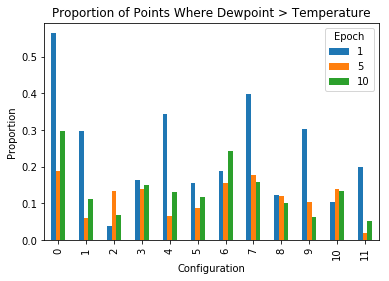

In [14]:
dewp_deps.plot(kind="bar")
plt.xlabel("Configuration")
plt.ylabel("Proportion")
plt.title("Proportion of Points Where Dewpoint > Temperature")
plt.legend(title="Epoch")

In [52]:
gen_model = load_model("/scratch/dgagne/storm_gan/gan_generator_000011_epoch_0010.h5")
enc_model = load_model("/scratch/dgagne/storm_gan/gan_encoder_000011_epoch_0010.h5")
disc_model = load_model("/scratch/dgagne/storm_gan/gan_discriminator_000011_0010.h5")

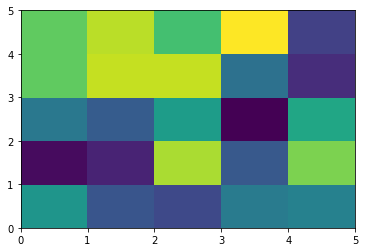

In [144]:
plt.pcolormesh(gen_model.layers[-2].get_weights()[0][:, :, 1, 0])

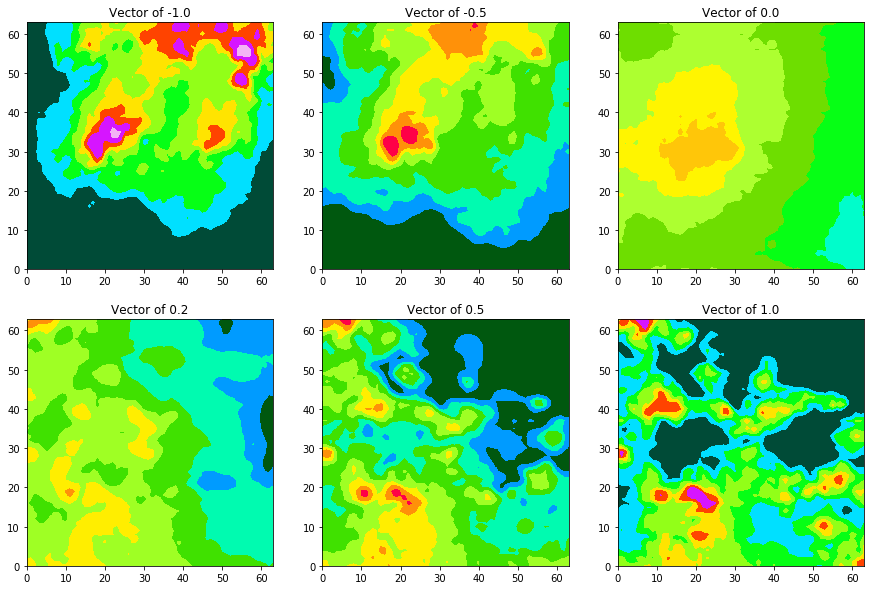

In [27]:
plt.figure(figsize=(15, 10))
for i, val in enumerate([-1, -0.5, 0, 0.25, 0.5, 1]):
    plt.subplot(2, 3, i + 1)
    plt.contourf(gen_model.predict(np.ones((1, 100)) * val)[0, :, :, 0], vmin=-1, vmax=1, cmap="gist_ncar")
    plt.title("Vector of {0:0.1f}".format(val))

In [43]:
enc_model.predict(gen_model.predict(np.ones((1, 100)) * 1))

array([[ 0.25634512,  0.76419938,  0.49604803,  0.84661257,  0.23623323,
         0.02193842,  0.44510674,  0.85071385,  0.95216155,  0.76056331,
         0.5378477 ,  0.78838295,  0.54042947,  0.64024901,  0.79916829,
         0.85588795,  0.76454508,  0.53344011,  0.55019599,  0.39812124,
         0.63353539,  0.57973862,  0.22962207,  0.89897692,  0.56120211,
         0.04224437,  0.54253995,  0.73489994,  0.7540493 ,  0.84252095,
         0.74618018,  0.70001072,  0.71812797,  0.72742212,  0.74352032,
         0.32357743,  0.82041174,  0.57297587,  0.37740505,  0.65665334,
         0.70833451,  0.37847003,  0.34350485,  0.75610614,  0.76242524,
         0.55817425,  0.83544981,  0.46107084,  0.87115443, -0.0660743 ,
         0.6189034 ,  0.45800358,  0.70262372,  0.55800247,  0.09281842,
         0.16621265,  0.71212506,  0.58925635,  0.72795796,  0.53902805,
         0.84275401,  0.85515761,  0.5982101 ,  0.50309145,  0.79386026,
         0.85372043,  0.78096259,  0.04543228,  0.7

In [181]:
stacked = stack_gen_encoder(gen_model, enc_model)

In [205]:
stacked.compile("adam", mae_var)

In [204]:
def mae_var(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred)) + 0.1 * K.abs(K.var(y_true) - K.var(y_pred))

In [213]:
train_vals = np.random.uniform(-1, 1, size=(10000, 10))
stacked.fit(train_vals, train_vals, batch_size=512, epochs=2)

Epoch 1/2
10000/10000 [==============================] - 39s - loss: 0.0559      

In [69]:
gen_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 512)         13107712  
_________________________________________________________________
activation_11 (Activation)   (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 16, 16, 256)       3277056   
_________________________________________________________________
activation_12 (Activation)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 32, 32, 128)       819328    
__________

In [68]:
disc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 64)        8064      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 256)         819456    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 512)         3277312   
__________

In [56]:
enc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 64)        8064      
_________________________________________________________________
activation_16 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
activation_17 (Activation)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 256)         819456    
_________________________________________________________________
activation_18 (Activation)   (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 4, 4, 512)         3277312   
__________

In [38]:
config_hist = pd.read_csv("/scratch/dgagne/storm_gan/gan_loss_history_000011.csv", parse_dates=["Time"])

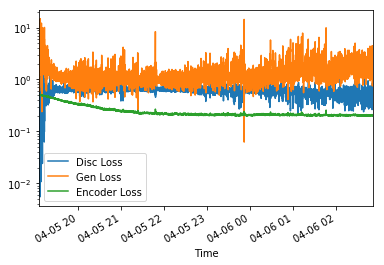

In [39]:
config_hist.plot(x="Time", y=["Disc Loss", "Gen Loss", "Encoder Loss"])
plt.gca().set_yscale("log")

In [47]:
for config in range(0, 12):
    config_hist = pd.read_csv("/scratch/dgagne/storm_gan/gan_loss_history_0000{0:02d}.csv".format(config), parse_dates=["Time"])
    print(config, pd.Timedelta(config_hist["Time"].values[-1] - config_hist["Time"].values[0]))

0 0 days 00:48:09.253060
1 0 days 01:38:51.912078
2 0 days 04:31:16.395090
3 0 days 01:05:19.832814
4 0 days 02:36:17.564285
5 0 days 07:52:44.632602
6 0 days 00:48:24.126082
7 0 days 01:39:58.636965
8 0 days 04:35:02.223595
9 0 days 01:04:47.392984
10 0 days 02:34:47.861063
11 0 days 07:46:42.757472


In [48]:
config_info = pd.read_csv("/scratch/dgagne/storm_gan/gan_param_combos.csv")

In [49]:
config_info

,Index,filter_width,generator_input_size,min_data_width,leaky_relu_alpha,learning_rate,max_conv_filters,batch_size,beta_one
0,0,5,10,2,0.2,0.0001,256,256,0.2
1,1,5,10,2,0.2,0.0001,512,256,0.2
2,2,5,10,2,0.2,0.0001,1024,256,0.2
3,3,5,10,4,0.2,0.0001,256,256,0.2
4,4,5,10,4,0.2,0.0001,512,256,0.2
5,5,5,10,4,0.2,0.0001,1024,256,0.2
6,6,5,100,2,0.2,0.0001,256,256,0.2
7,7,5,100,2,0.2,0.0001,512,256,0.2
8,8,5,100,2,0.2,0.0001,1024,256,0.2
9,9,5,100,4,0.2,0.0001,256,256,0.2


20480